In [1]:
# add explainn subfolder to os path
import sys
sys.path.append('..')
from explainn import tools
from explainn import networks
from explainn import train
from explainn import test
from explainn import interpretation

import torch
import os
import json
from torch import nn
from sklearn.metrics import average_precision_score
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sys.path.append('../scripts')
from utils import (get_file_handle, get_seqs_labels_ids, get_data_loader,
                   get_device)

Load a model

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir = "../../SCRATCH/AS-TAC/ExplaiNN/single_train/100_units_merged_21_25"
model_dir_list = os.listdir(model_dir)

In [3]:
import pandas as pd


# Load the JSON file
with open(model_dir + '/parameters-train.py.json', 'r') as f:
    data = json.load(f)

# Convert the dictionary into a DataFrame
df = pd.DataFrame([data])

# find the .pth file in weight_file list
for file in model_dir_list:
    if file.endswith(".pth"):
        weight_file = file
        break


In [4]:
handle=get_file_handle(model_dir + '/parameters-train.py.json', "rt")
train_args = json.load(handle)
handle.close()
# if "training_file" in train_args: # i.e. for fine-tuned models
#     handle = get_file_handle(train_args["training_file"], "rt")
#     train_args = json.load(handle)
#     handle.close()

In [5]:
train_args

{'batch_size': 100,
 'checkpoint': 0,
 'cpu_threads': 1,
 'criterion': 'BCEWithLogits',
 'debugging': False,
 'filter_size': 19,
 'input_length': 1000,
 'lr': 0.005,
 'num_epochs': 200,
 'num_fc': 2,
 'num_units': 100,
 'optimizer': 'Adam',
 'output_dir': '/net/fs-2/scale/OrionStore/Scratch/asfj/AS-TAC/ExplaiNN/single_train/100_units_merged_21_25',
 'patience': 10,
 'pool_size': 7,
 'pool_stride': 7,
 'rev_complement': False,
 'time': False,
 'training_file': '/net/fs-2/scale/OrionStore/Scratch/asfj/AS-TAC/AS-TAC_merged_21_25_train.tsv',
 'trim_weights': False,
 'validation_file': '/net/fs-2/scale/OrionStore/Scratch/asfj/AS-TAC/AS-TAC_merged_21_25_test.tsv'}

In [6]:
model_dir

'../../SCRATCH/AS-TAC/ExplaiNN/single_train/100_units_merged_21_25'

In [6]:
num_cnns = df.iloc[0]['num_units']
input_length = df.iloc[0]['input_length']
num_classes = 21
filter_size = df.iloc[0]['filter_size']

explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)
explainn.load_state_dict(torch.load(model_dir + "/" + weight_file, map_location=torch.device('cpu')))
explainn.eval();

In [7]:
networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size, num_fc=1).to(device)
#explainn

ExplaiNN(
  (linears): Sequential(
    (0): Conv1d(400, 100, kernel_size=(19,), stride=(1,), groups=100)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpActivation()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Unsqueeze()
    (6): Conv1d(14000, 100, kernel_size=(1,), stride=(1,), groups=100)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=100, out_features=21, bias=True)
)

In [8]:
from torchsummary import summary
import torch
import torch.nn as nn
summary(explainn, (4,1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 100, 982]           7,700
       BatchNorm1d-2             [-1, 100, 982]             200
     ExpActivation-3             [-1, 100, 982]               0
         MaxPool1d-4             [-1, 100, 140]               0
           Flatten-5                [-1, 14000]               0
         Unsqueeze-6             [-1, 14000, 1]               0
            Conv1d-7             [-1, 10000, 1]       1,410,000
       BatchNorm1d-8             [-1, 10000, 1]          20,000
              ReLU-9             [-1, 10000, 1]               0
          Dropout-10             [-1, 10000, 1]               0
           Conv1d-11               [-1, 100, 1]          10,100
      BatchNorm1d-12               [-1, 100, 1]             200
             ReLU-13               [-1, 100, 1]               0
          Flatten-14                  [

In [9]:
weights = explainn.final.weight.detach().cpu().numpy()

In [10]:
# load target_labels
with open("../../SCRATCH/AS-TAC/bed_list_merged.txt", 'r') as f:
    target_labels = f.read().splitlines()

# Remove "AS-TAC-peaks/AtlanticSalmon_ATAC_" and ".mLb.clN_peaks.narrowPeak" from the strings in labels list
target_labels = [label.replace("AS-TAC-merged_peaks/AtlanticSalmon_ATAC_", "").replace("AS-TAC-peaks/AtlanticSalmon_ATAC_","").replace(".mRp.clN_peaks.narrowPeak", "").replace("Immature","I").replace("Mature","M").replace("Somitogenesis","S").replace("Gastrulation","G").replace("Blastulation","B").replace("Male","M").replace("Female","F") for label in target_labels]


In [11]:
len(target_labels)
target_labels


['Brain_I_F',
 'Brain_I_M',
 'Brain_M_F',
 'Brain_M_M',
 'EarlyS',
 'Gonad_I_F',
 'Gonad_I_M',
 'Gonad_M_F',
 'Gonad_M_M',
 'LateB',
 'LateS',
 'Liver_I_F',
 'Liver_I_M',
 'Liver_M_F',
 'Liver_M_M',
 'MidG',
 'MidS',
 'Muscle_I_F',
 'Muscle_I_M',
 'Muscle_M_F',
 'Muscle_M_M']

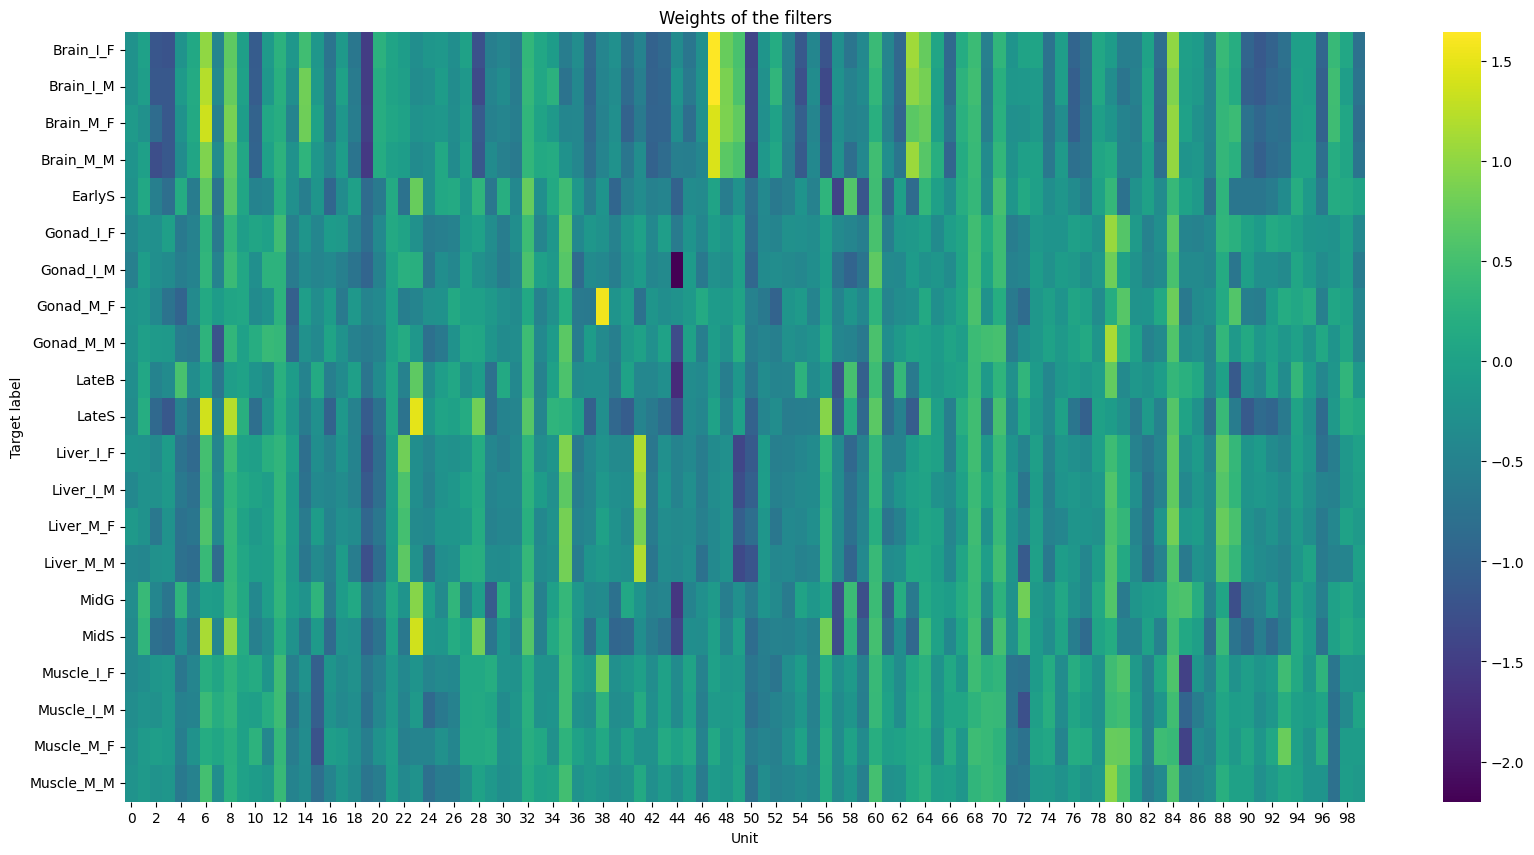

In [12]:
# make a heatmap of weights, y axis is the filter number, x axis is the position in the filter
weights = explainn.final.weight.detach().cpu().numpy()

# give weigts row names from target_labels
weights = pd.DataFrame(weights, index=target_labels)
#sort weights by alphabet on row names
weights = weights.sort_index()
plt.figure(figsize=(20,10))
sns.heatmap(weights, cmap="viridis")
plt.ylabel("Target label")
plt.xlabel("Unit")

plt.title("Weights of the filters")
plt.show()
#plt.savefig(model_dir + "/weights.png")


TOMTOM FROM HERE

In [14]:
model_dir

'../../SCRATCH/AS-TAC/ExplaiNN/single_train/100_units_merged_21_25'

In [13]:
#unzip the gz file in the path (model_dir + "/tomtom/tomtom.tsv.gz")
import gzip
import shutil
with gzip.open(model_dir + "/tomtom/tomtom.tsv.gz", 'rb') as f_in:
    with open(model_dir + "/tomtom/tomtom.tsv", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

FileNotFoundError: [Errno 2] No such file or directory: '../../SCRATCH/AS-TAC/ExplaiNN/single_train/100_units_merged_21_25/tomtom/tomtom.tsv.gz'

In [14]:
tomtom_results = pd.read_csv(model_dir + "/tomtom/tomtom.tsv",
                                        sep="\t",comment="#")

filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]

tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]

cisbp_motifs = {}
with open("../../SCRATCH/downloads/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]
    if len(target_id) > 5:
        target_id = target_id[:5]
    ann = "/".join([cisbp_motifs[i] for i in target_id.values])
    annotation[f] = ann

annotation = pd.Series(annotation)
annotation

filter36                      TFAP2C/TFAP2B/TFAP2A
filter46          CREM/FOSB::JUN/ATF3/JUNB/CREB3L4
filter56        Pparg::Rxra/NR2C2/THRB/Nr2f6/NR2F1
filter32               ZNF281/ZNF148/SP3/MAZ/KLF14
filter24                             POU3F3/POU3F2
filter42                            CTCF/CTCF/CTCF
filter53                                      CTCF
filter49             Foxl2/FOXS1/FOXC1/FOXC2/FOXB1
filter4                  Lhx1/EMX1/DRGX/HOXC8/LHX6
filter39                    KLF15/KLF7/MAZ/SP4/SP1
filter50                            CTCF/CTCF/CTCF
filter28               NR2C2/NR2C1/THRB/PPARD/RXRB
filter19                            CTCF/CTCF/CTCF
filter63            NFIC::TLX1/NFIX/NFIX/NFIB/NFIC
filter55                                    POU3F3
filter70                                 NFYC/NFYA
filter88    FOXJ2::ELF1/ELF4/ELF2/ETV2::FOXI1/ETV1
filter69                                      THRA
dtype: object

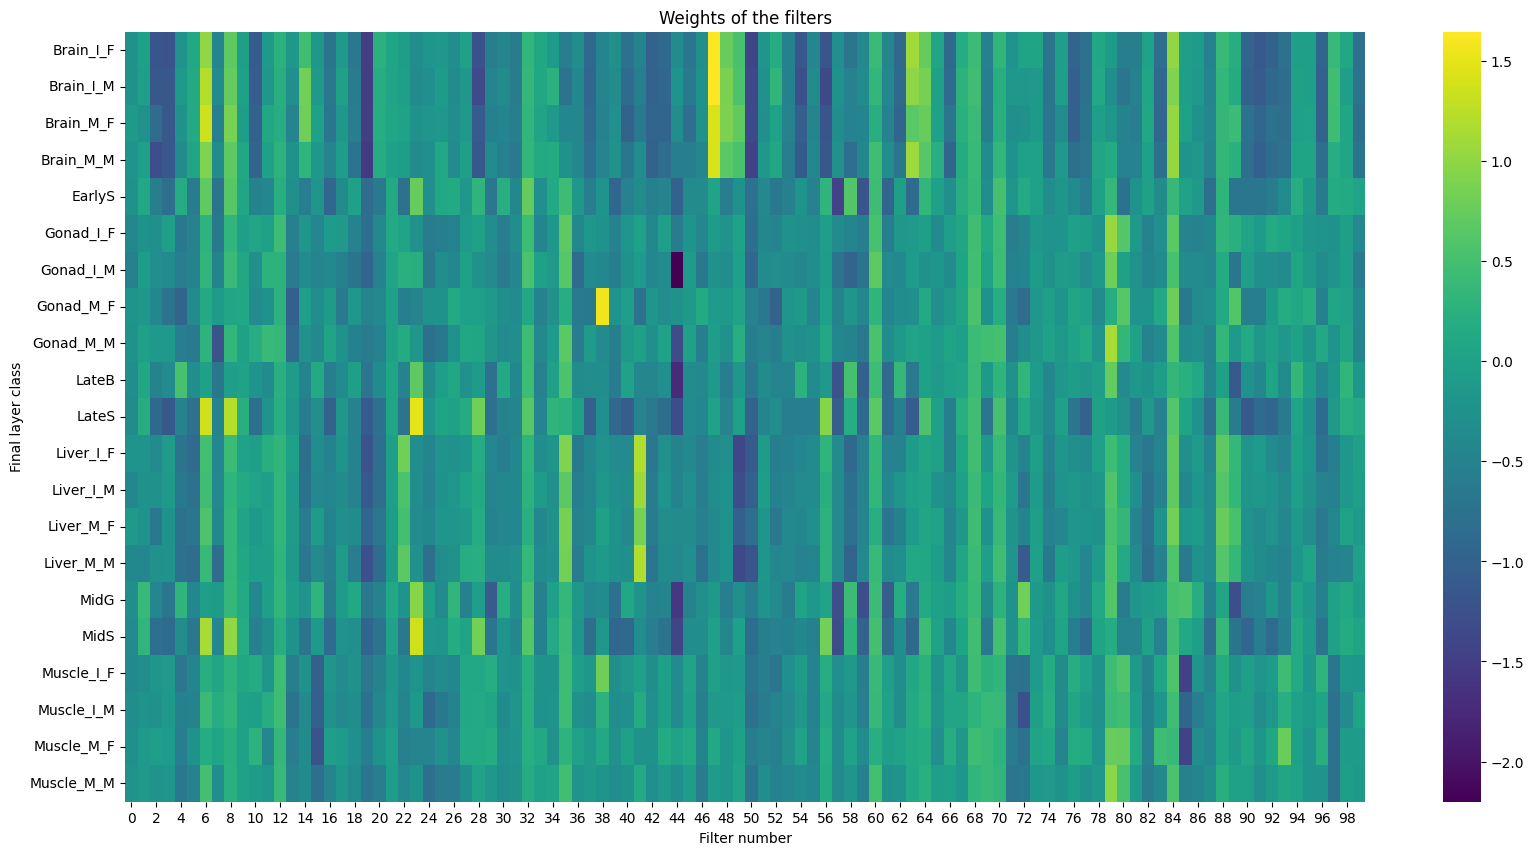

In [15]:
# make a heatmap of weights, y axis is the filter number, x axis is the position in the filter
plt.figure(figsize=(20,10))
sns.heatmap(weights, cmap="viridis")
plt.ylabel("Final layer class")
plt.xlabel("Filter number")
plt.title("Weights of the filters")
plt.show()

In [18]:
annotation

filter36                      TFAP2C/TFAP2B/TFAP2A
filter46          CREM/FOSB::JUN/ATF3/JUNB/CREB3L4
filter56        Pparg::Rxra/NR2C2/THRB/Nr2f6/NR2F1
filter32               ZNF281/ZNF148/SP3/MAZ/KLF14
filter24                             POU3F3/POU3F2
filter42                            CTCF/CTCF/CTCF
filter53                                      CTCF
filter49             Foxl2/FOXS1/FOXC1/FOXC2/FOXB1
filter4                  Lhx1/EMX1/DRGX/HOXC8/LHX6
filter39                    KLF15/KLF7/MAZ/SP4/SP1
filter50                            CTCF/CTCF/CTCF
filter28               NR2C2/NR2C1/THRB/PPARD/RXRB
filter19                            CTCF/CTCF/CTCF
filter63            NFIC::TLX1/NFIX/NFIX/NFIB/NFIC
filter55                                    POU3F3
filter70                                 NFYC/NFYA
filter88    FOXJ2::ELF1/ELF4/ELF2/ETV2::FOXI1/ETV1
filter69                                      THRA
dtype: object

In [16]:
weights = explainn.final.weight.detach().cpu().numpy()
import re
filters = ["filter"+str(i) for i in range(num_cnns)]
for i in annotation.keys():
    #filters[int(i.split("filter")[-1])] = annotation[i]
    # Extract only the digits from the string
    num = re.findall('\d+', i.split("filter")[-1])
    # num is a list of all numeric sequences in the string, take the first
    filters[int(num[0])] = annotation[i]
    
weight_df = pd.DataFrame(weights,index=target_labels,columns=filters)
weight_df.shape

<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\aslak\AppData\Local\Temp\ipykernel_14236\2044401100.py:7: SyntaxWarning: invalid escape sequence '\d'
  num = re.findall('\d+', i.split("filter")[-1])


(21, 100)

<Figure size 640x480 with 0 Axes>

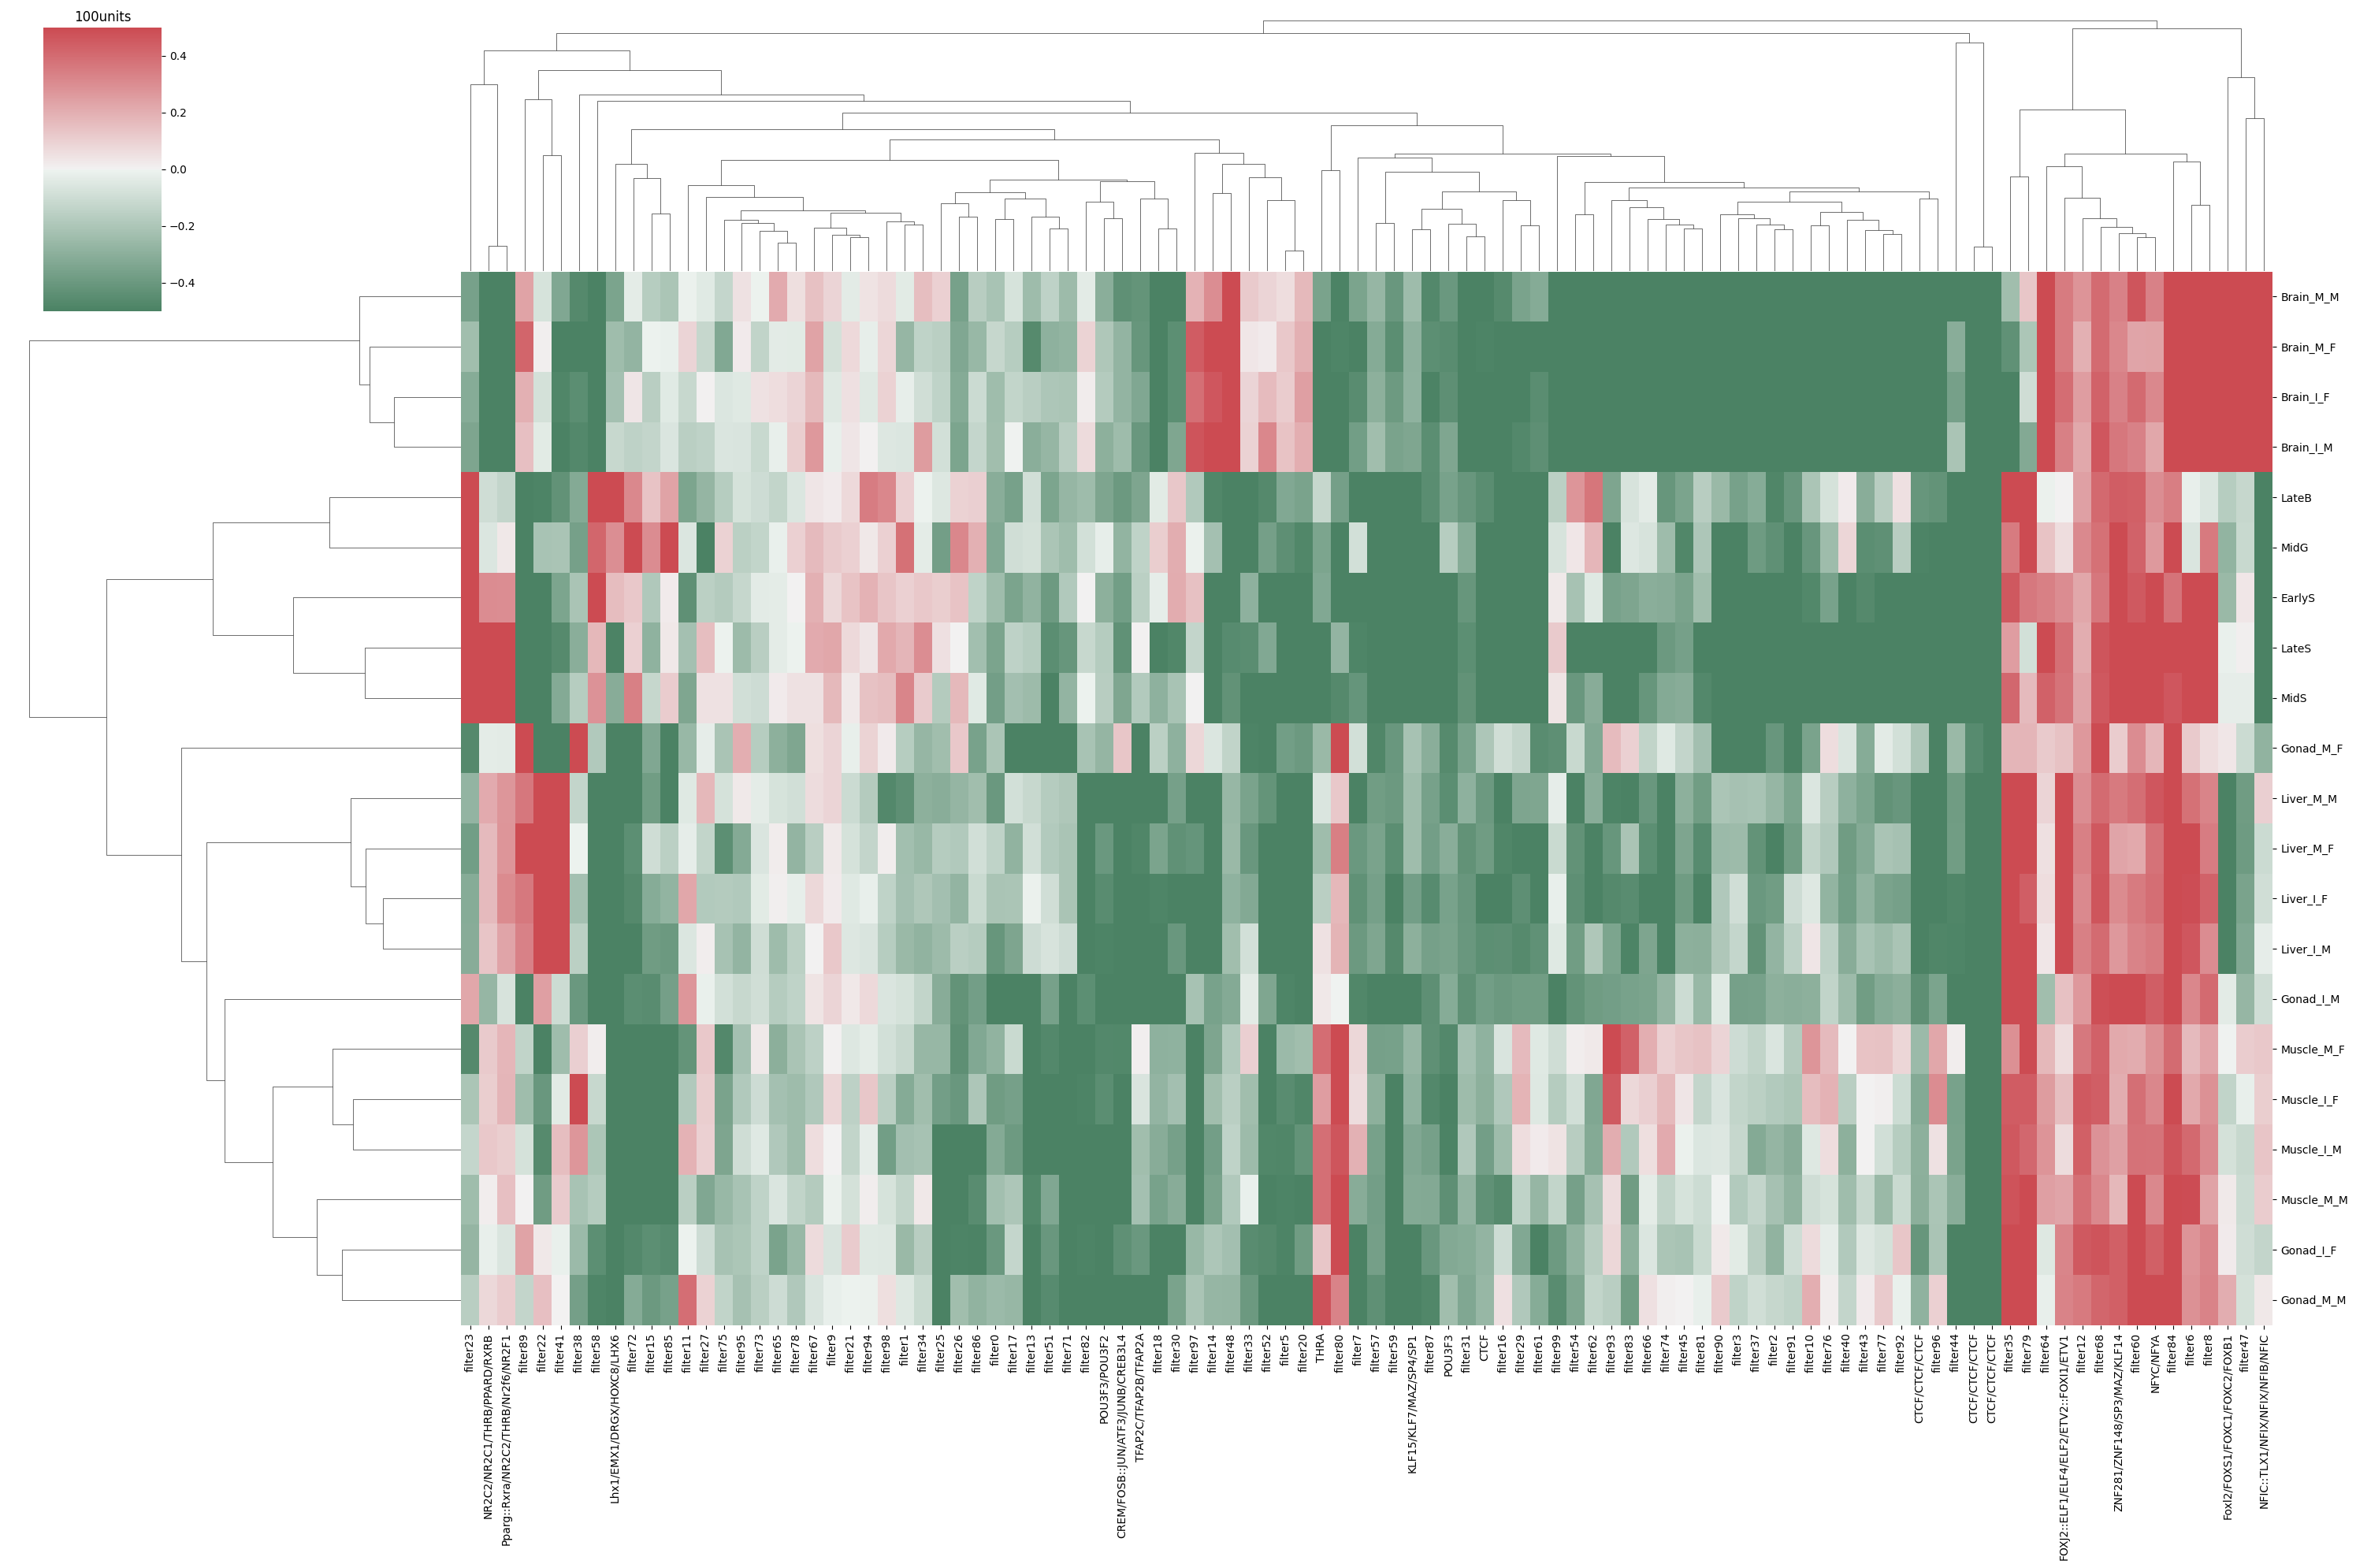

In [17]:
plt.figure()
sns.clustermap(weight_df,cmap=sns.diverging_palette(145, 10, s=60, as_cmap=True), 
               row_cluster=True, figsize=(30,20), vmax=0.5, vmin = -0.5)
plt.title(str(num_cnns) + "units")

plt.show()

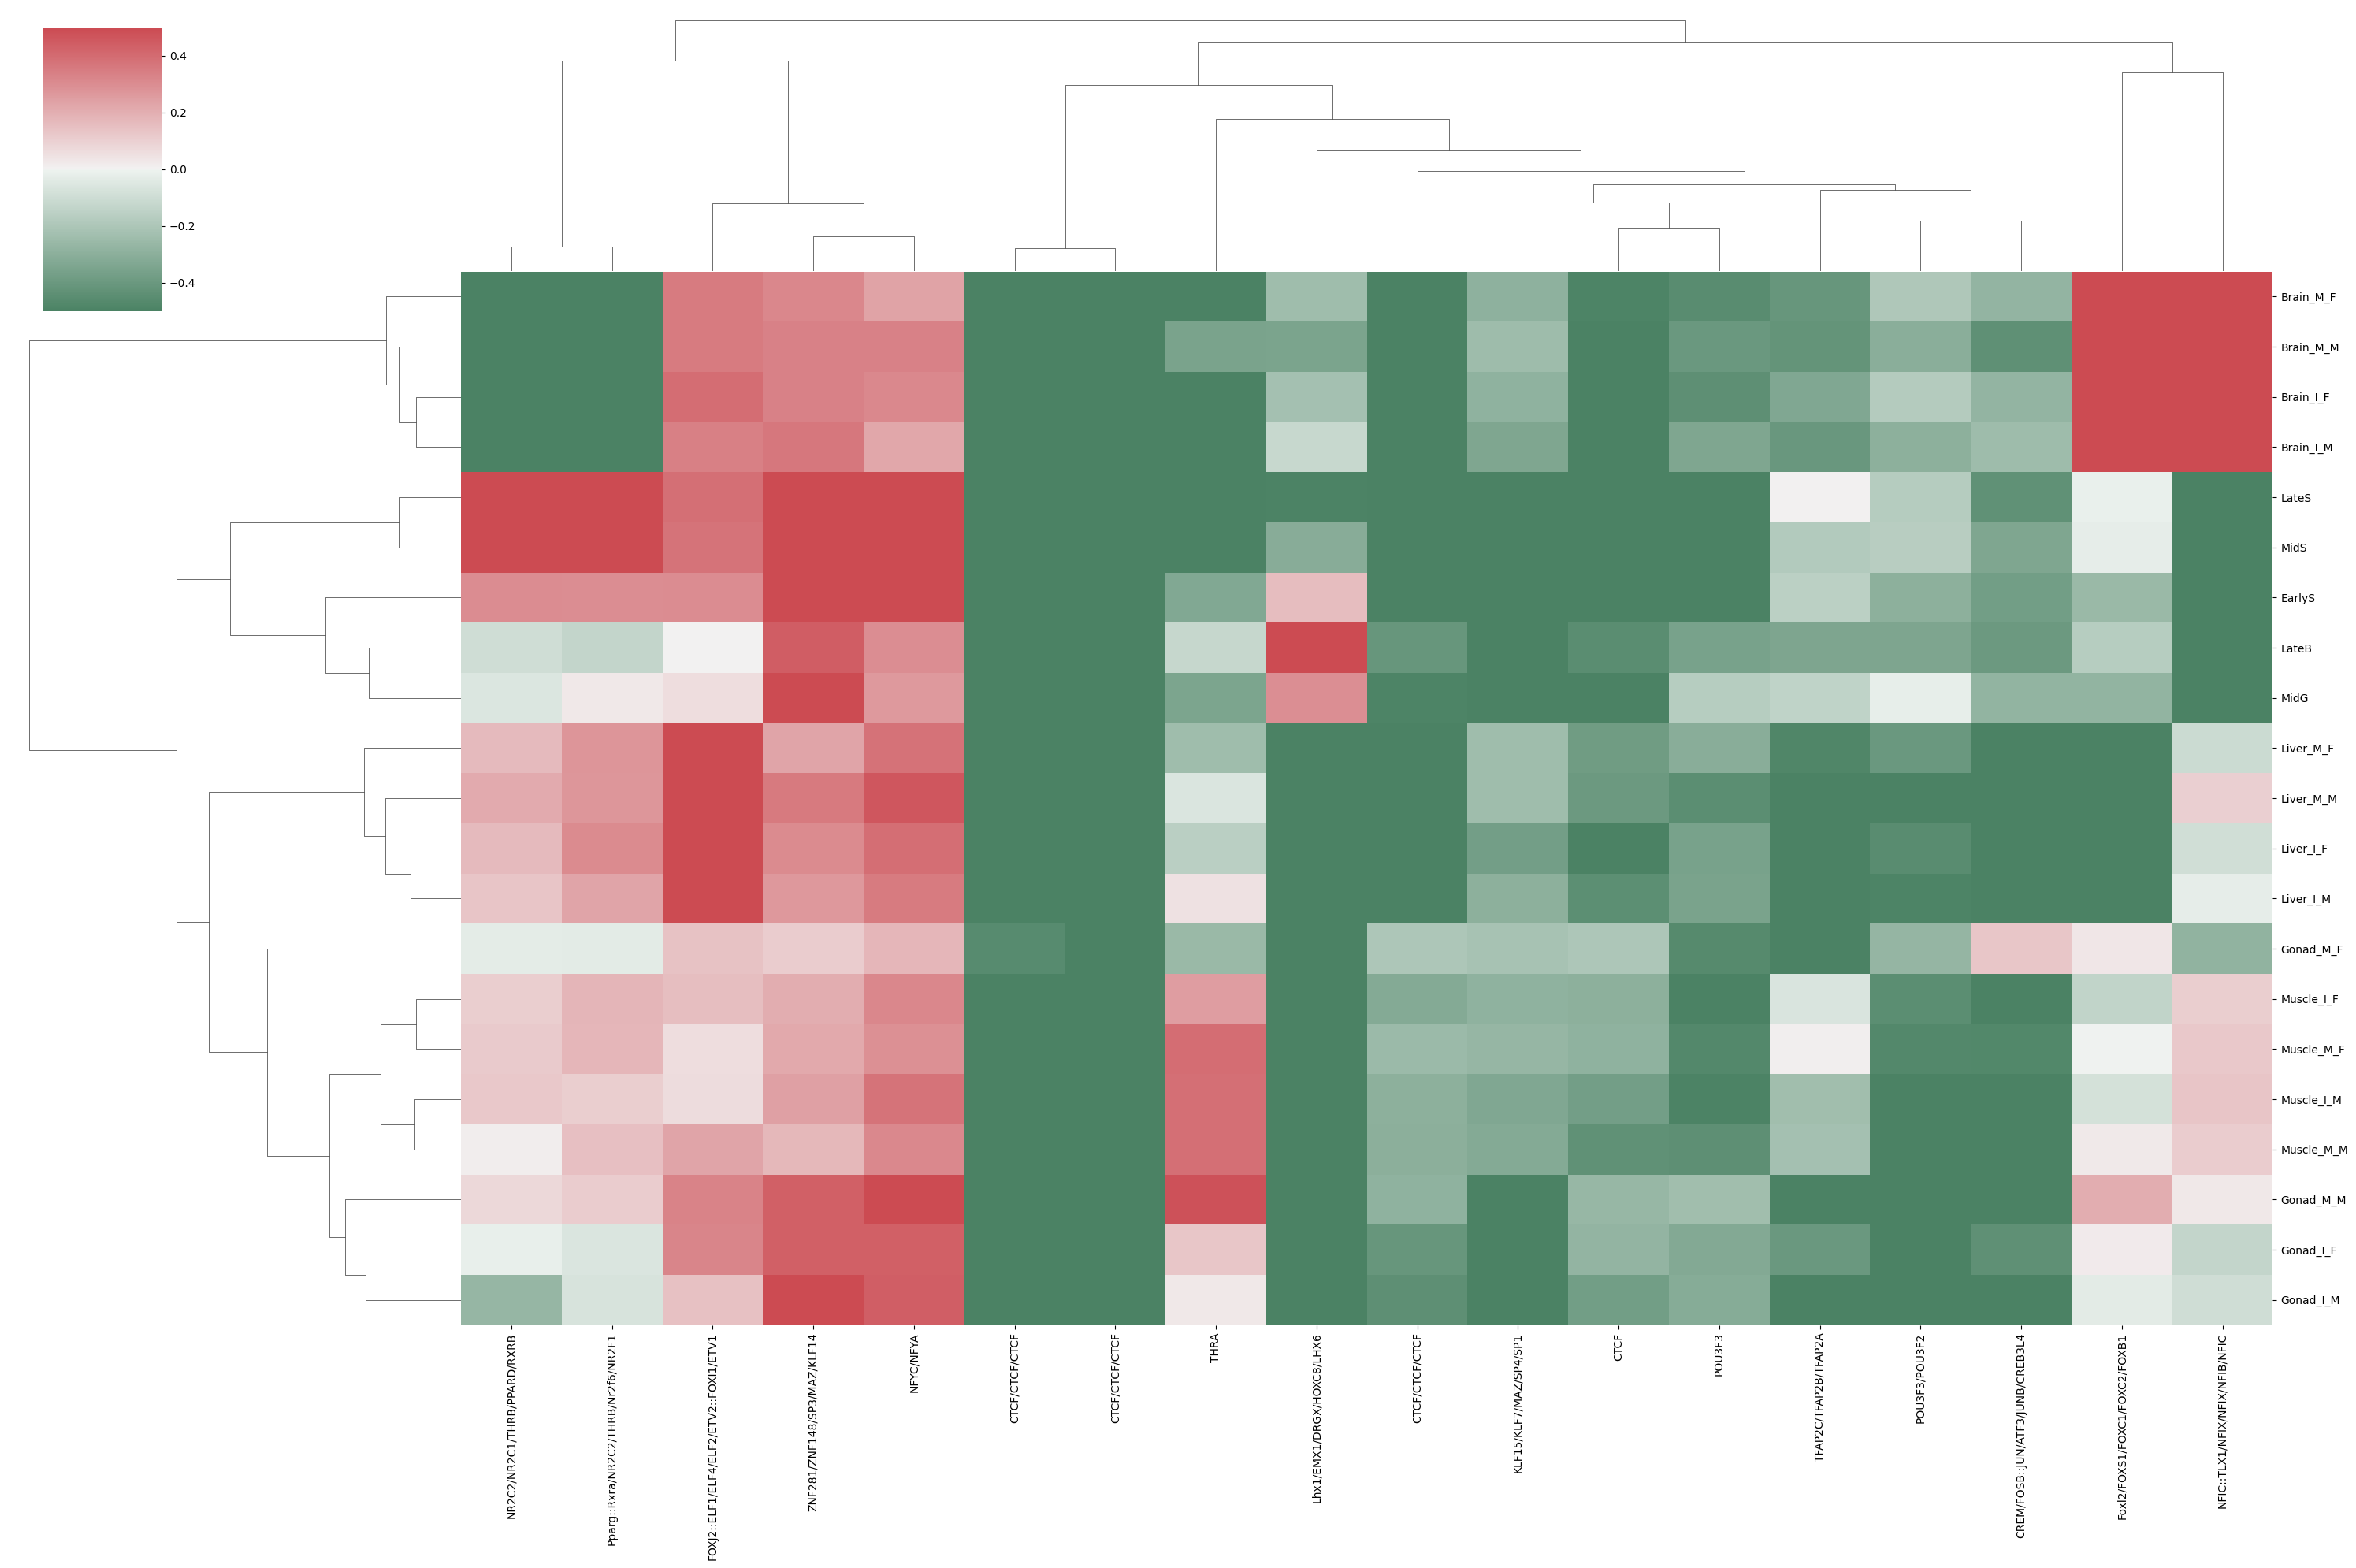

In [21]:
#only annotated columns
ann_wdf = weight_df.loc[:,["filter" not in i for i in list(weight_df)]]

clust = sns.clustermap(ann_wdf, cmap=sns.diverging_palette(145, 10, s=60, as_cmap=True), 
               row_cluster=True, figsize=(30,20), vmax=0.5, vmin = -0.5)

In [27]:
seqs, labels, _ = get_seqs_labels_ids("../../SCRATCH/AS-TAC/AS-TAC_merged_21_25_test.tsv", target_labels, False, 1000)

# Get training DataLoader
data_loader = get_data_loader(seqs, labels, 100)

In [23]:
annotation  

filter36                      TFAP2C/TFAP2B/TFAP2A
filter46          CREM/FOSB::JUN/ATF3/JUNB/CREB3L4
filter56        Pparg::Rxra/NR2C2/THRB/Nr2f6/NR2F1
filter32               ZNF281/ZNF148/SP3/MAZ/KLF14
filter24                             POU3F3/POU3F2
filter42                            CTCF/CTCF/CTCF
filter53                                      CTCF
filter49             Foxl2/FOXS1/FOXC1/FOXC2/FOXB1
filter4                  Lhx1/EMX1/DRGX/HOXC8/LHX6
filter39                    KLF15/KLF7/MAZ/SP4/SP1
filter50                            CTCF/CTCF/CTCF
filter28               NR2C2/NR2C1/THRB/PPARD/RXRB
filter19                            CTCF/CTCF/CTCF
filter63            NFIC::TLX1/NFIX/NFIX/NFIB/NFIC
filter55                                    POU3F3
filter70                                 NFYC/NFYA
filter88    FOXJ2::ELF1/ELF4/ELF2/ETV2::FOXI1/ETV1
filter69                                      THRA
dtype: object

In [24]:
batch_size=100
predictions, labels = interpretation.get_explainn_predictions(data_loader, explainn, device, isSigmoid=True)

# only well predicted sequences
pred_full_round = np.round(predictions)
arr_comp = np.equal(pred_full_round, labels)
idx = np.argwhere(np.sum(arr_comp, axis=1) == len(target_labels)).squeeze()

#data_inp = data_inp[idx, :, :]
##data_out = data_out[idx, :]

# #dataset = torch.utils.data.TensorDataset(data_inp, data_out)
# #data_loader = torch.utils.data.DataLoader(dataset=data_,
#                                           batch_size=batch_size, shuffle=False,
#                                                   num_workers=0)

activations = interpretation.get_explainn_unit_activations(data_loader, explainn, device)
pwms = interpretation.get_pwms_explainn(activations, seqs, filter_size)
interpretation.pwm_to_meme(pwms, model_dir + "/testing_interpretation.meme")

ValueError: operands could not be broadcast together with shapes (1000,21) (1000,49) 

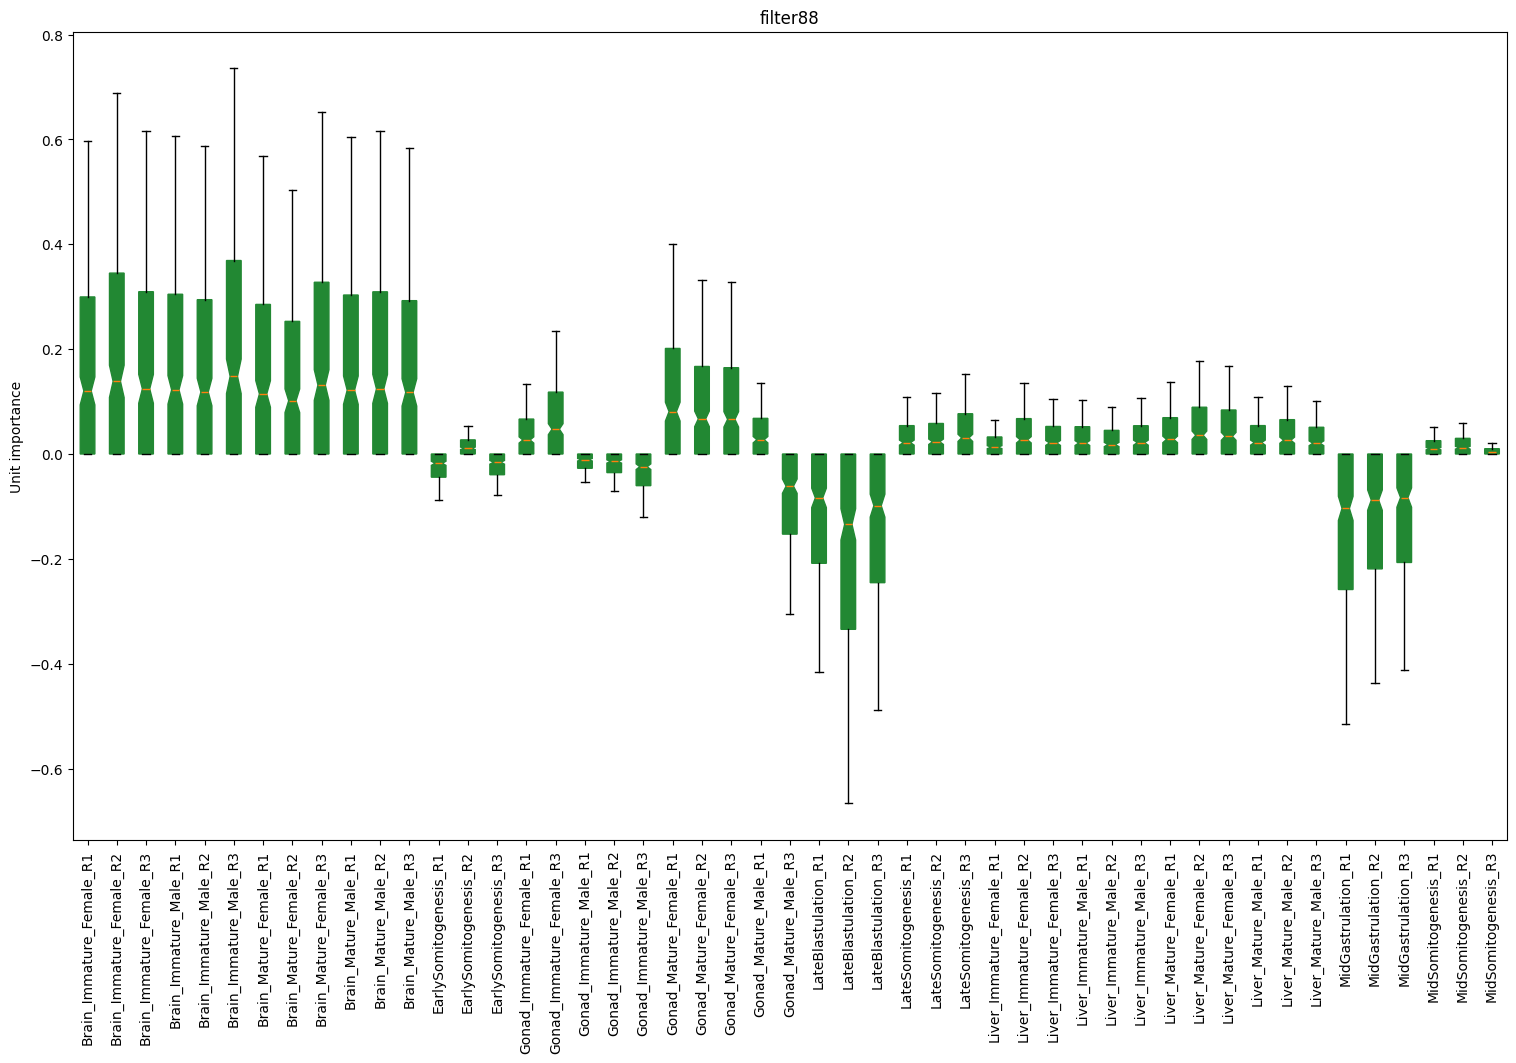

In [ ]:


unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)

unit_importance = interpretation.get_specific_unit_importance(activations, explainn, unit_outputs, 88, target_labels)

filter_key = "filter"+str(88)
title = annotation[filter_key] if filter_key in annotation.index else filter_key
fig, ax = plt.subplots()


datas = [filt_dat for filt_dat in unit_importance]
# sort datas by the words before the first underscore in target_labels
datas = [x for _, x in sorted(zip(target_labels, datas))]
#sort target labels by the words before the first underscore
target_labels_sorted = sorted(target_labels)
ax.boxplot(datas, notch=True, patch_artist=True, boxprops=dict(facecolor="#228833", color="#228833"))
fig.set_size_inches(18.5, 10.5)
plt.title(title)
plt.ylabel("Unit importance")
plt.xticks(range(1, len(target_labels_sorted)+1), target_labels_sorted)
plt.xticks(rotation=90)
plt.show()

In [ ]:
weights.shape

(49, 100)

In [ ]:
weights_tensor = torch.from_numpy(weights)
U, S, V = torch.svd(weights_tensor)


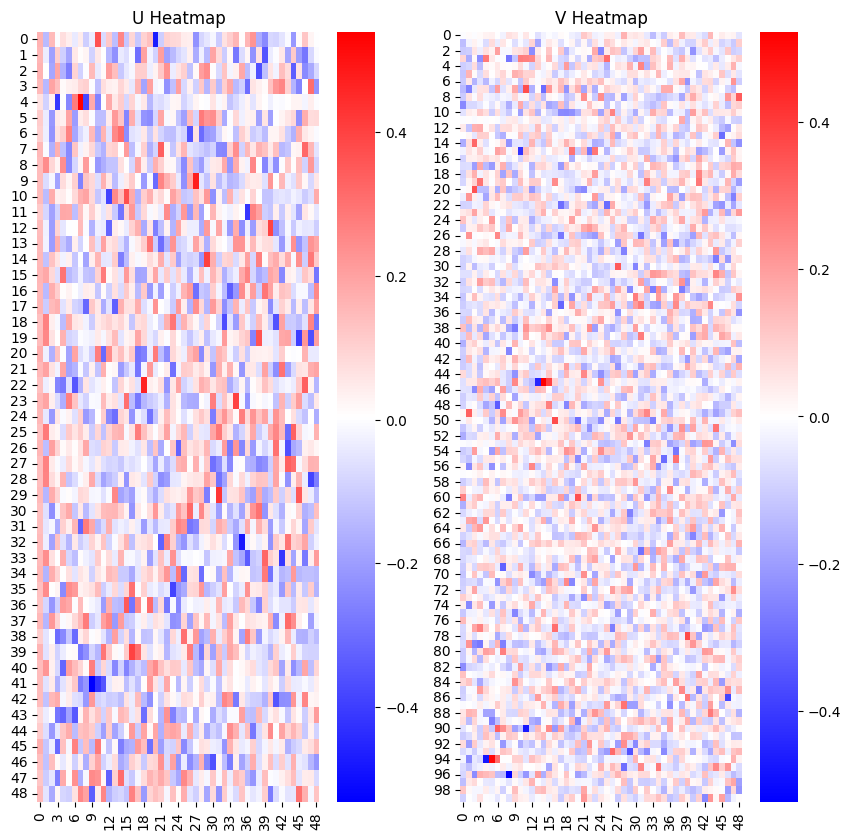

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

U_numpy = U.cpu().numpy()
V_numpy = V.cpu().numpy()

plt.figure(figsize=(10,10))

# Heatmap for U
plt.subplot(1, 2, 1)
sns.heatmap(U_numpy, cmap='bwr')
plt.title('U Heatmap')

# Heatmap for V
plt.subplot(1, 2, 2)
sns.heatmap(V_numpy, cmap='bwr')
plt.title('V Heatmap')

plt.show()

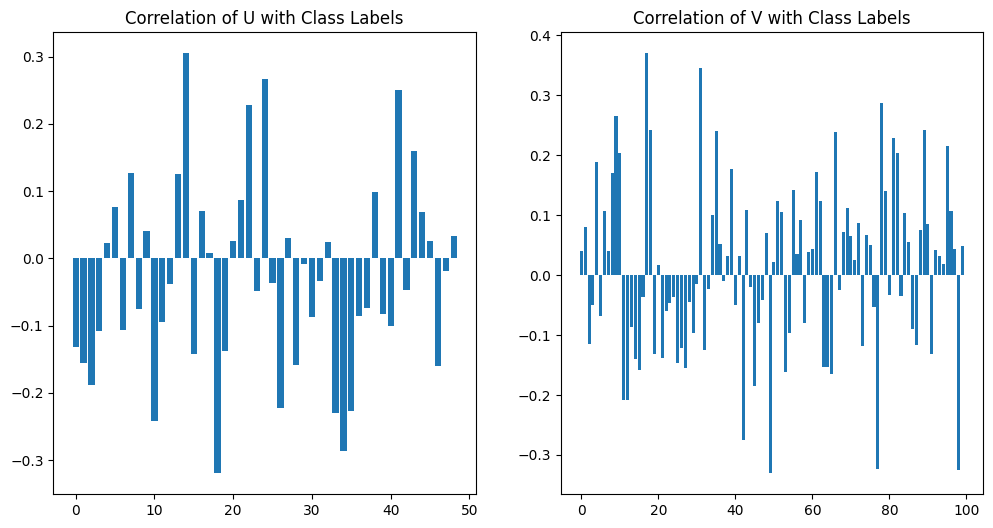

In [ ]:
import numpy as np
import scipy.stats as stats

class_labels = range(0,len(target_labels))
U_numpy = U.cpu().numpy() # Convert U to numpy array
V_numpy = V.cpu().numpy() # Convert V to numpy array

correlation_U = [stats.pearsonr(U_numpy[i], class_labels)[0] for i in range(U_numpy.shape[0])]
correlation_V = [stats.pearsonr(V_numpy[i], class_labels)[0] for i in range(V_numpy.shape[0])]

import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(12, 6))

# Create a subplot for U
plt.subplot(1, 2, 1)
plt.bar(range(len(correlation_U)), correlation_U)
plt.title('Correlation of U with Class Labels')

# Create a subplot for V
plt.subplot(1, 2, 2)
plt.bar(range(len(correlation_V)), correlation_V)
plt.title('Correlation of V with Class Labels')

# Show the plot
plt.show()

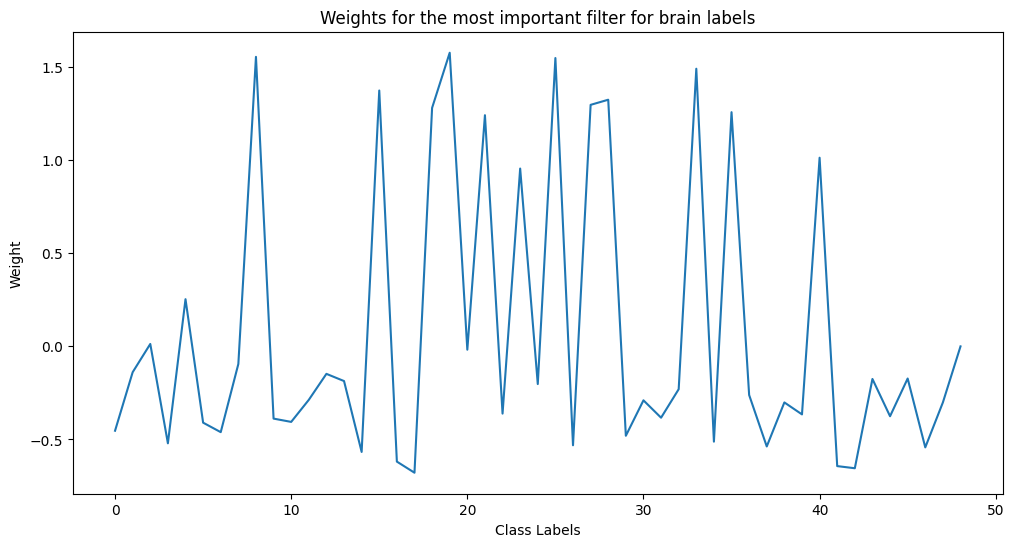

In [ ]:
weights=explainn.final.weight.detach().cpu().numpy()

# Do SVD analysis on the weights
U, S, V = np.linalg.svd(weights)

# Create a new figure
plt.figure(figsize=(12, 6))
# Find out which filter is the most important for labels that start with "Brain"
brain_labels = [label for label in target_labels if label.startswith('Brain')]
# Find the indices of the brain labels
brain_indices = [target_labels.index(label) for label in brain_labels]
# Get the weights for the brain labels
brain_weights = weights[brain_indices]
# Find the most important filter for the brain labels
most_important_filter = np.argmax(np.sum(brain_weights, axis=0))
# Plot the weights for the most important filter
plt.plot(weights[:, most_important_filter])
plt.title('Weights for the most important filter for brain labels')
plt.xlabel('Class Labels')
plt.ylabel('Weight')
plt.show()


In [ ]:
most_important_filter

49